<a href="https://colab.research.google.com/github/nilabja10201992/Cryptocurrency-Price-Prediction/blob/master/compare_LSTM_GRU_CONV1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9,la;q=0.8,hi;q=0.7,fr;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/1346/330249/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556692071&Signature=JKsfB4DXsi178h5Th5nVO9XclVPnr2skZpy97UY6CC0gCRvpcR%2Fg13rO5AaX3ReMqd1rum%2BwidFXorsHBCmkUxxrGwZBKPUq1egenh%2BYzT5lPExCwty8ludzxMAmzXKmMaNRwaq0eIxKyeZlzjYAGfvLLDcXGd7QZSJ6eofWXhS6iCK%2FfzkkCUTEBj0zspZ6xVvHQLYaDdfcwXeB1dC2%2BVfZQ3siRdqX%2FRFWZfiG4tBKxq4K2rlJT5FQEQTctaAKJVUYlXD679GWtzSf5ElcfZckN0xhmAuBawp8IGRB36mH%2Fo1VjWSDrBy0rSEmSSTGCCN6TDLFnS0OrWHJG%2Bc4Qg%3D%3D" -O "bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip" -c

--2019-04-28 15:02:08--  https://storage.googleapis.com/kaggle-datasets/1346/330249/bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1556692071&Signature=JKsfB4DXsi178h5Th5nVO9XclVPnr2skZpy97UY6CC0gCRvpcR%2Fg13rO5AaX3ReMqd1rum%2BwidFXorsHBCmkUxxrGwZBKPUq1egenh%2BYzT5lPExCwty8ludzxMAmzXKmMaNRwaq0eIxKyeZlzjYAGfvLLDcXGd7QZSJ6eofWXhS6iCK%2FfzkkCUTEBj0zspZ6xVvHQLYaDdfcwXeB1dC2%2BVfZQ3siRdqX%2FRFWZfiG4tBKxq4K2rlJT5FQEQTctaAKJVUYlXD679GWtzSf5ElcfZckN0xhmAuBawp8IGRB36mH%2Fo1VjWSDrBy0rSEmSSTGCCN6TDLFnS0OrWHJG%2Bc4Qg%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71025792 (68M) [application/zip]
Saving to: ‘bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip’

bitstampUSD_1-min_d 100%[===================>]  67.7

In [0]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.86 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3" --header="Accept-Language: en-US,en;q=0.9,la;q=0.8,hi;q=0.7,fr;q=0.6" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-datasets/1346/330249/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1554396067&Signature=dDgUcw%2BomKNghqJ1vvJ4ZWoFep8TlxEFxBxR%2FV%2BsZehJ%2BnTSjcY5eUueteFNc7bkX2SU%2Beb5dhmVhfa7lv6N17v5BXWsGUnN3nMkQKBCVSlsIdZjv6%2FqA2y6B0t15jCMTPoCu1KdmuYVWc%2B9oWiZD2mMCVxzNsqB8j3CewsJYzbqJGPYbKiTcu1RRsgbgqxkvYKreWi7yQX1MCYAuKknwmeI2zwbjH0IT3FwQWkVTWpJpE3Jk7xLrkNYrlfVsSy%2BqDs06gnsw9kuYL1y%2B9en4Pb%2Bm1YzlL7XD%2FPWd5PrdQRnWNyhGbT5Ab0mGOUwCwMxwd8Z4bn6XY2ofXv9LChkMw%3D%3D" -O "coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip" -c

--2019-04-28 15:02:15--  https://storage.googleapis.com/kaggle-datasets/1346/330249/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1554396067&Signature=dDgUcw%2BomKNghqJ1vvJ4ZWoFep8TlxEFxBxR%2FV%2BsZehJ%2BnTSjcY5eUueteFNc7bkX2SU%2Beb5dhmVhfa7lv6N17v5BXWsGUnN3nMkQKBCVSlsIdZjv6%2FqA2y6B0t15jCMTPoCu1KdmuYVWc%2B9oWiZD2mMCVxzNsqB8j3CewsJYzbqJGPYbKiTcu1RRsgbgqxkvYKreWi7yQX1MCYAuKknwmeI2zwbjH0IT3FwQWkVTWpJpE3Jk7xLrkNYrlfVsSy%2BqDs06gnsw9kuYL1y%2B9en4Pb%2Bm1YzlL7XD%2FPWd5PrdQRnWNyhGbT5Ab0mGOUwCwMxwd8Z4bn6XY2ofXv9LChkMw%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.130.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.130.128|:443... connected.
HTTP request sent, awaiting response... 400 Bad Request
2019-04-28 15:02:15 ERROR 400: Bad Request.



In [0]:
!unzip bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip

Archive:  bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv  


In [0]:
!ls

bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv
bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv.zip
coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv.zip
sample_data


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Library for Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Convolution1D, MaxPooling1D, Flatten, Activation
from keras.optimizers import SGD
import math
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [0]:
def mean_absolute_scaled_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    dem = 0
    num = 0
    for i in range(n-1):
        dem += y_true[i+1] - y_true[i]
    for i in range(n):
        num = abs(y_pred[i] - y_true[i])
        num = np.squeeze(num)
        res += num/dem
    res = np.squeeze(res)
    #print(num, dem, res)
    return res/n

In [0]:
def systematic_mean_absolute_percentage_error(y_true, y_pred):
    n = y_true.shape[0]
    res = 0
    for i in range(n):
        num = np.abs(y_pred[i] - y_true[i])
        dem = (np.abs(y_true[i]) + np.abs(y_pred[i]))/2
        res += num/dem
    res = np.squeeze(res)
    return 100*(res/n)

In [0]:
train_df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2019-03-13.csv")
train_df.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.778817e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06,2.551132e+06
mean,1.438908e+09,2.654668e+03,2.656783e+03,2.652286e+03,2.654650e+03,1.068140e+01,2.395856e+04,2.654510e+03
std,6.561491e+07,3.529553e+03,3.533184e+03,3.525347e+03,3.529522e+03,3.476243e+01,8.829950e+04,3.529271e+03
min,1.325318e+09,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.382000e+09,3.489800e+02,3.491500e+02,3.487800e+02,3.489900e+02,4.500000e-01,2.480382e+02,3.489681e+02
50%,1.439071e+09,6.595600e+02,6.600000e+02,6.589900e+02,6.596200e+02,2.095163e+00,1.814312e+03,6.595521e+02
75%,1.495753e+09,4.045492e+03,4.049115e+03,4.042050e+03,4.045400e+03,8.284949e+00,1.303504e+04,4.045115e+03
max,1.552435e+09,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,5.483271e+06,1.966330e+04


In [0]:
a = train_df[1200000:].fillna(method="backfill")
a.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,time,day,day_Fri,day_Mon,day_Sat,day_Sun,day_Thu,day_Tue,day_Wed
1200000,1397317920,423.70,423.70,423.68,423.68,4.000000,1694.754000,423.688500,"Sat, 12 Apr 2014 15:52:00 +0000",Sat,0,0,1,0,0,0,0
1200001,1397317980,423.67,423.67,423.67,423.67,0.950200,402.571234,423.670000,"Sat, 12 Apr 2014 15:53:00 +0000",Sat,0,0,1,0,0,0,0
1200002,1397318040,423.60,423.60,423.55,423.55,1.517910,642.931121,423.563400,"Sat, 12 Apr 2014 15:54:00 +0000",Sat,0,0,1,0,0,0,0
1200003,1397318100,423.55,423.55,423.55,423.55,1.000000,423.550000,423.550000,"Sat, 12 Apr 2014 15:55:00 +0000",Sat,0,0,1,0,0,0,0
1200004,1397318160,423.48,423.49,423.48,423.49,1.039435,440.186555,423.486431,"Sat, 12 Apr 2014 15:56:00 +0000",Sat,0,0,1,0,0,0,0


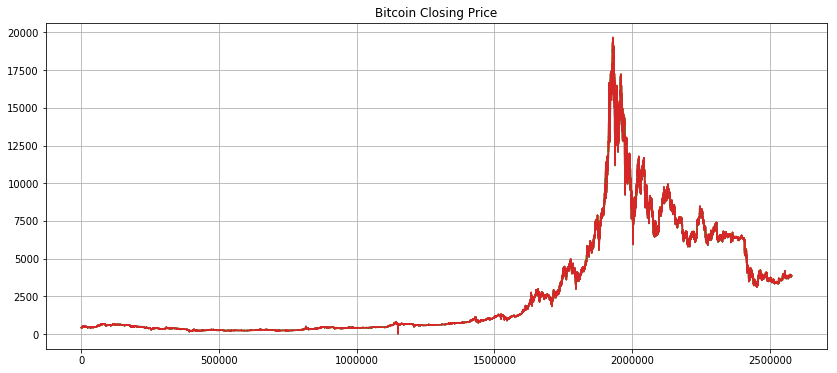

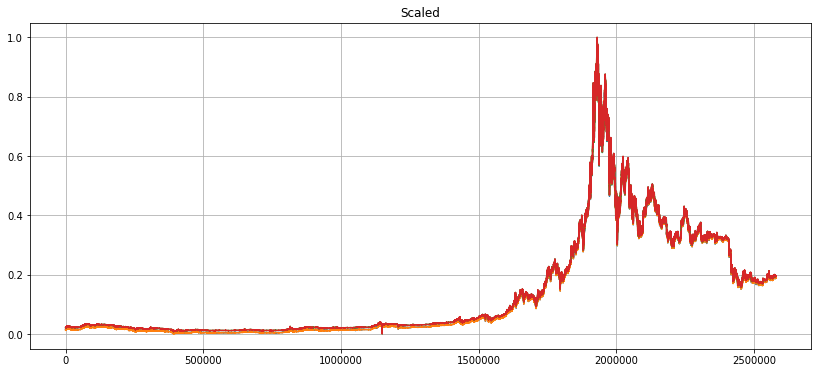

In [0]:
weighted_price = np.array(a.iloc[:,[1,2,3,4]])
plt.figure(figsize=(14,6))
plt.title("Bitcoin Closing Price")
plt.grid()
plt.plot(weighted_price)
sclow = MinMaxScaler()
low_price = np.array(a.iloc[:,[3]])
low_priceSC = sclow.fit_transform(low_price)
sc = MinMaxScaler()
weighted_priceSC = sc.fit_transform(weighted_price)
plt.figure(figsize=(14,6))
plt.title("Scaled")
plt.grid()
plt.plot(weighted_priceSC)

In [0]:
timestep = 60
X = []
y = []
for i in range(timestep, len(weighted_priceSC)):
    X.append(weighted_priceSC[i-timestep:i, :])
    y.append(low_priceSC[i])
X, y = np.array(X), np.array(y)
print(X.shape, y.shape)

(2578757, 60, 4) (2578757, 1)


In [0]:
print(X.shape, y.shape)

(2578757, 60, 4) (2578757, 1)


In [0]:
X_train = X[:2400000,:]
X_test = X[2400000:,:]

y_train = y[:2400000]
y_test = y[2400000:]

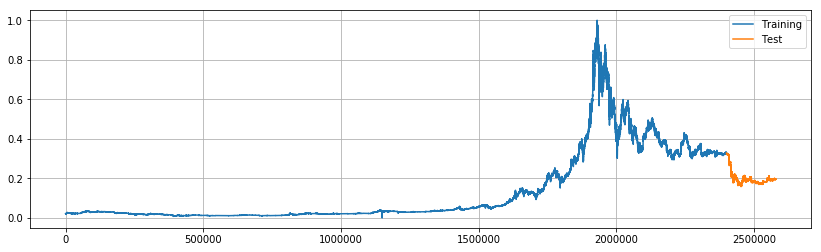

In [0]:
plt.figure(figsize=(14,4))
plt.plot(range(2400000),y_train)
plt.plot(range(2400000, len(y)), y_test)
plt.legend(["Training", "Test"])
plt.grid()


In [0]:
X_train = X_train.reshape(-1,timestep,4)
X_test = X_test.reshape(-1,timestep,4)

In [20]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=128, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(LSTM(units=256))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history = regressor.fit(X_train, y_train, epochs=5, batch_size=2048)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
2400000/2400000 [==============================] - 545s 227us/step - loss: 0.0086
Epoch 2/5
2400000/2400000 [==============================] - 541s 225us/step - loss: 0.0067
Epoch 3/5
2400000/2400000 [==============================] - 540s 225us/step - loss: 0.0066
Epoch 4/5
2400000/2400000 [==============================] - 539s 225us/step - loss: 0.0065
Epoch 5/5
2400000/2400000 [==============================] - 537s 224us/step - loss: 0.0065
CPU times: user 53min 16s, sys: 6min 11s, total: 59min 28s
Wall time: 45min 6s


In [21]:
%%time
y_pred = regressor.predict(X_test)

CPU times: user 18min 25s, sys: 2min 21s, total: 20min 46s
Wall time: 12min 17s


In [22]:
y_testSC = sclow.inverse_transform(y_test.reshape(-1,1))
y_predSC = sclow.inverse_transform(y_pred.reshape(-1,1))
y_testSC.shape

(178757, 1)

Text(0, 0.5, 'Price')

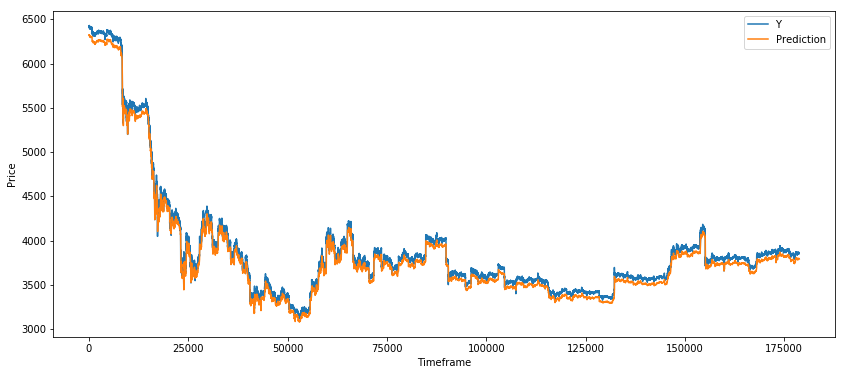

In [23]:
plt.figure(figsize=(14,6))
plt.plot(y_testSC[:,0])
plt.plot(y_predSC[:,0])
#plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")


In [34]:
print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}".format(mean_absolute_error(y_test, y_pred),systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred)))

Mean absolute error 0.003287332082688564
Systematic mean absolute percentage error 1.671782115931768 
Mean_absolute_scaled_error -0.025195138508062574


In [35]:
%%time
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(GRU(units=32, return_sequences=True, input_shape=(X_train.shape[1],4)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(GRU(units=64, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(GRU(units=128, return_sequences=True))
regressor.add(Dropout(0.5))
# Fourth LSTM layer
regressor.add(GRU(units=256))
regressor.add(Dropout(0.5))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history = regressor.fit(X_train, y_train, epochs=10, batch_size=2048)

Epoch 1/10
2400000/2400000 [==============================] - 433s 180us/step - loss: 0.0090
Epoch 2/10
2400000/2400000 [==============================] - 432s 180us/step - loss: 0.0069
Epoch 3/10
2400000/2400000 [==============================] - 433s 180us/step - loss: 0.0065
Epoch 4/10
2400000/2400000 [==============================] - 433s 180us/step - loss: 0.0064
Epoch 5/10
2400000/2400000 [==============================] - 436s 182us/step - loss: 0.0063
Epoch 6/10
2400000/2400000 [==============================] - 433s 181us/step - loss: 0.0064
Epoch 7/10
2400000/2400000 [==============================] - 434s 181us/step - loss: 0.0063
Epoch 8/10
2400000/2400000 [==============================] - 432s 180us/step - loss: 0.0063
Epoch 9/10
2400000/2400000 [==============================] - 431s 180us/step - loss: 0.0063
Epoch 10/10
2400000/2400000 [==============================] - 432s 180us/step - loss: 0.0062
CPU times: user 1h 30min 27s, sys: 10min 5s, total: 1h 40min 32s
Wall

In [36]:
%%time
y_pred = regressor.predict(X_test)

CPU times: user 16min 29s, sys: 1min 39s, total: 18min 8s
Wall time: 10min 41s


In [37]:
y_testSC = sclow.inverse_transform(y_test.reshape(-1,1))
y_predSC = sclow.inverse_transform(y_pred.reshape(-1,1))
y_testSC.shape

(178757, 1)

Text(0, 0.5, 'Price')

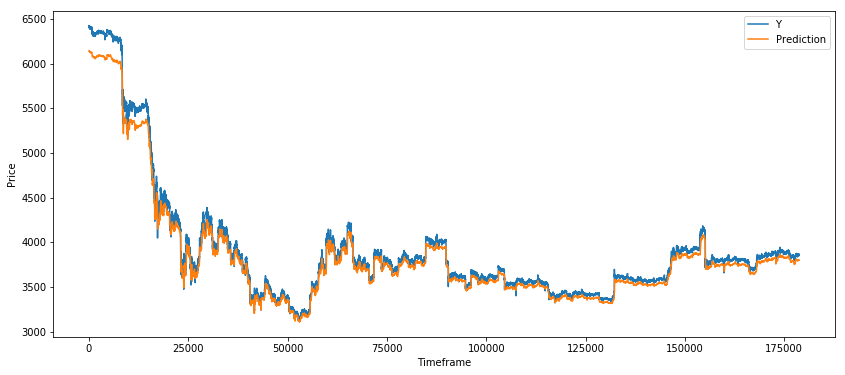

In [38]:
plt.figure(figsize=(14,6))
plt.plot(y_testSC[:,0])
plt.plot(y_predSC[:,0])
#plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")


In [39]:
print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}".format(mean_absolute_error(y_test, y_pred),systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred)))

Mean absolute error 0.0035281282228558026
Systematic mean absolute percentage error 1.6601800234794843 
Mean_absolute_scaled_error -0.027040675238491532


In [64]:
%%time
# The LSTM architecture
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (X_train.shape[1],4), border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))
# Compiling the RNN
model.compile(optimizer='adam', loss='mean_absolute_error')
# Fitting to the training set
history = model.fit(X_train, y_train, epochs=10, batch_size=2048)

Epoch 1/10
2400000/2400000 [==============================] - 80s 33us/step - loss: 0.0040
Epoch 2/10
2400000/2400000 [==============================] - 74s 31us/step - loss: 0.0022
Epoch 3/10
2400000/2400000 [==============================] - 73s 31us/step - loss: 0.0020
Epoch 4/10
2400000/2400000 [==============================] - 74s 31us/step - loss: 0.0018
Epoch 5/10
2400000/2400000 [==============================] - 73s 31us/step - loss: 0.0016
Epoch 6/10
2400000/2400000 [==============================] - 73s 31us/step - loss: 0.0016
Epoch 7/10
2400000/2400000 [==============================] - 73s 30us/step - loss: 0.0016
Epoch 8/10
2400000/2400000 [==============================] - 74s 31us/step - loss: 0.0015
Epoch 9/10
2400000/2400000 [==============================] - 73s 31us/step - loss: 0.0014
Epoch 10/10
2400000/2400000 [==============================] - 73s 30us/step - loss: 0.0015
CPU times: user 14min 52s, sys: 1min 30s, total: 16min 22s
Wall time: 12min 22s


In [67]:
%%time
y_pred = model.predict(X_test)

CPU times: user 2min 41s, sys: 17.4 s, total: 2min 58s
Wall time: 1min 46s


In [68]:
y_testSC = sclow.inverse_transform(y_test.reshape(-1,1))
y_predSC = sclow.inverse_transform(y_pred.reshape(-1,1))
y_testSC.shape

(178757, 1)

Text(0, 0.5, 'Price')

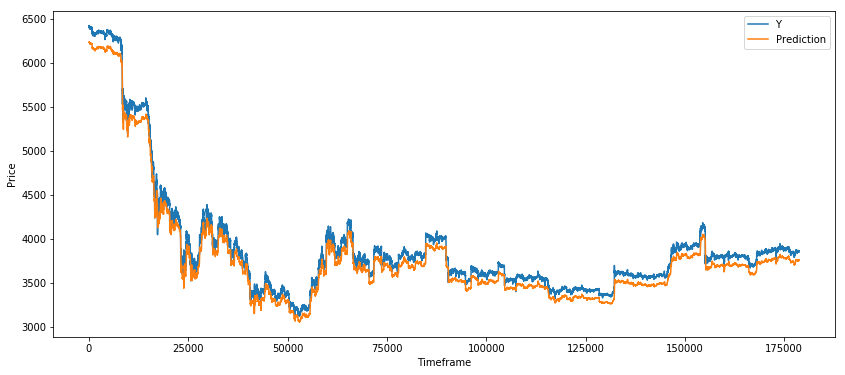

In [69]:
plt.figure(figsize=(14,6))
plt.plot(y_testSC[:,0])
plt.plot(y_predSC[:,0])
#plt.title("Comparison with MAE {0:0.10f}".format(MAE))
plt.legend(["Y", "Prediction"])
plt.xlabel("Timeframe")
plt.ylabel("Price")

In [71]:
print("Mean absolute error {0}\nSystematic mean absolute percentage error {1} \nMean_absolute_scaled_error {2}".format(mean_absolute_error(y_test, y_pred),systematic_mean_absolute_percentage_error(y_test, y_pred), mean_absolute_scaled_error(y_test, y_pred)))

Mean absolute error 0.005410171473786334
Systematic mean absolute percentage error 2.7483466223942337 
Mean_absolute_scaled_error -0.04146524178443553
